In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup #remove html tags
import unicodedata #remove accented characters

#tokenization
import nltk
from nltk.tokenize.toktok import ToktokTokenizer

#remove special characters
import re

import spacy

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
!pip install contractions

In [3]:

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Import the libraries, load dataset, print shape of data, data description.

In [4]:
data = pd.read_csv('Tweets.csv')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
data.shape

(14640, 15)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

# 2. Understand of data-columns

In [7]:
# a. Drop all other columns except “text” and “airline_sentiment”.
tweets = data.iloc[:14640,[1,10]]
tweets

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


In [8]:
# checking for null data
tweets.isnull().sum()

airline_sentiment    0
text                 0
dtype: int64

In [9]:
# b. Check the shape of data.
tweets.shape

(14640, 2)

In [10]:
# c. Print first 5 rows of data.
pd.set_option('display.max_colwidth',None)
tweets.head(10)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it
5,negative,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6,positive,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)"
7,neutral,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."


# 3. Text pre-processing: Data preparation. 

In [11]:
# a. Html tag removal.
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

tweets_a = tweets.copy()
tweets_a['text'] = tweets_a['text'].apply(lambda x: strip_html(x))
tweets_a.head(10)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it
5,negative,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6,positive,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)"
7,neutral,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."


In [12]:
# Remove contractions
import contractions
def replace_contractions(text):
    return contractions.fix(text)

tweets_a['text'] = tweets_a['text'].apply(lambda x: replace_contractions(x))
tweets_a.head(10)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it
5,negative,@VirginAmerica seriously would pay $30 a flight for seats that did not have this playing.\nit is really the only bad thing about flying VA
6,positive,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” will not go away :)"
7,neutral,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
8,positive,"@virginamerica Well, I did not…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an hour early. you are too good to me."


In [13]:
# b. Tokenization.
tokenizer=ToktokTokenizer()

def tokenization(text):
    token = tokenizer.tokenize(text)
    return token
    
    
tweets_b = tweets_a.copy()
tweets_b['text'] = tweets_b['text'].apply(lambda x: tokenization(x))
tweets_b

,airline_sentiment,text
0,neutral,"[@VirginAmerica, What, @dhepburn, said, .]"
1,positive,"[@VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[@VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[@VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, "", entertainment, "", in, your, guests, ', faces, &amp;, they, have, little, recourse]"
4,negative,"[@VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]"
...,...,...
14635,positive,"[@AmericanAir, thank, you, we, got, on, a, different, flight, to, Chicago, .]"
14636,negative,"[@AmericanAir, leaving, over, 20, minutes, Late, Flight., No, warnings, or, communication, until, we, were, 15, minutes, Late, Flight., that, is, called, shitty, customer, svc]"
14637,neutral,"[@AmericanAir, Please, bring, American, Airlines, to, #BlackBerry10]"
14638,negative,"[@AmericanAir, you, have, my, money, ,, you, change, my, flight, ,, and, do, not, answer, your, phones, !, Any, other, suggestions, so, I, can, make, my, commitment?, ?]"


In [14]:
# c & d. Remove the numbers.
def remove_num_specialChar(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

tweets_d = tweets_a.copy()
tweets_d['text'] = tweets_d['text'].apply(lambda x: remove_num_specialChar(x,remove_digits=True))
tweets_d.head(10)                          

,airline_sentiment,text
0,neutral,VirginAmerica What dhepburn said
1,positive,VirginAmerica plus you have added commercials to the experience tacky
2,neutral,VirginAmerica I did not today Must mean I need to take another trip
3,negative,VirginAmerica it is really aggressive to blast obnoxious entertainment in your guests faces they have little recourse
4,negative,VirginAmerica and it is a really big bad thing about it
5,negative,VirginAmerica seriously would pay a flight for seats that did not have this playing\nit is really the only bad thing about flying VA
6,positive,VirginAmerica yes nearly every time I fly VX this ear worm will not go away
7,neutral,VirginAmerica Really missed a prime opportunity for Men Without Hats parody there httpstcomWpGgrEZP
8,positive,virginamerica Well I did notbut NOW I DO D
9,positive,VirginAmerica it was amazing and arrived an hour early you are too good to me


In [15]:
# b. Tokenization.
tokenizer=ToktokTokenizer()

def tokenization(text):
    token = tokenizer.tokenize(text)
    return token
    
    
tweets_b = tweets_d.copy()
tweets_b['text'] = tweets_b['text'].apply(lambda x: tokenization(x))
tweets_b

,airline_sentiment,text
0,neutral,"[VirginAmerica, What, dhepburn, said]"
1,positive,"[VirginAmerica, plus, you, have, added, commercials, to, the, experience, tacky]"
2,neutral,"[VirginAmerica, I, did, not, today, Must, mean, I, need, to, take, another, trip]"
3,negative,"[VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]"
4,negative,"[VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]"
...,...,...
14635,positive,"[AmericanAir, thank, you, we, got, on, a, different, flight, to, Chicago]"
14636,negative,"[AmericanAir, leaving, over, minutes, Late, Flight, No, warnings, or, communication, until, we, were, minutes, Late, Flight, that, is, called, shitty, customer, svc]"
14637,neutral,"[AmericanAir, Please, bring, American, Airlines, to, BlackBerry]"
14638,negative,"[AmericanAir, you, have, my, money, you, change, my, flight, and, do, not, answer, your, phones, Any, other, suggestions, so, I, can, make, my, commitment]"


In [16]:
# create stop words list

sw = stopwords.words('english')
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [17]:
# create list of excepted negation words like "not,isn't,etc.." as these words are important to define the sentiments .
myList = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

stopswords = list(set(sw) - set(myList))
print(stopswords)

['i', "you're", "you'd", 'other', 'whom', 'been', 'very', 'it', 'had', 'or', 'did', 'that', 'on', 'do', 'up', 'through', 'his', 'theirs', 'just', "that'll", 'a', 'were', 'until', 'if', 'm', 'again', 'couldn', 'against', 'themselves', 'from', 'y', 'while', 'aren', 'him', 'you', 'above', 't', 'own', 'over', 'no', "don't", 'd', 'so', 'then', 'be', 'o', 'where', 'into', "aren't", 'their', 'few', 'only', 'am', 'the', 'her', 'as', 'don', 'we', 'me', 'does', 'to', 'further', 'my', 'than', 'ours', 'off', 'he', 'yourselves', "you've", 'with', 'this', 'each', 'which', 'who', "she's", "should've", 'these', 'more', 'both', 'myself', 'being', 've', 'out', 'how', 'is', 'below', 'such', 'your', 'between', 'but', 'what', 'an', 'those', 'and', 'because', 'here', 'should', 'itself', 'are', "you'll", 'have', 'yours', 'of', 'will', 'during', 're', 'after', 'there', 'has', 'll', 'she', 'them', "it's", 'hers', 'why', 'once', 'for', 'herself', 'was', 'nor', 's', 'doing', 'when', 'our', 'in', 'about', 'having

In [18]:
# Remove accented characters, convert to lower case, remove punctuation, remove stopwords, Lemmatization,
# Join the words in the list to convert back to text string 
from nltk.stem.wordnet import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopswords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
        new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

tweets_b['text'] = tweets_b.apply(lambda row: normalize(row['text']), axis=1)
tweets_b.head(5)

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience tacky
2,neutral,virginamerica not today must mean need take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,negative,virginamerica really big bad thing


In [19]:
# make copy of the processed data
tweets_final = tweets_b.copy()

# 4. Vectorization: 

In [20]:
# a. Use CountVectorizer.

# Keep only 2000 features to reduce processing time.
vectorizer = CountVectorizer(max_features=2000)               
tweets_CountVectorizer = vectorizer.fit_transform(tweets_final['text'])
# Convert the data features to array.
tweets_CountVectorizer = tweets_CountVectorizer.toarray()                        

In [21]:
tweets_CountVectorizer.shape

(14640, 2000)

In [22]:
print(len(vectorizer.vocabulary_))
print(vectorizer.vocabulary_)

2000
{'virginamerica': 1889, 'say': 1540, 'plus': 1334, 'add': 26, 'experience': 637, 'not': 1197, 'today': 1777, 'must': 1162, 'mean': 1094, 'need': 1174, 'take': 1721, 'another': 88, 'trip': 1808, 'really': 1423, 'entertainment': 596, 'face': 650, 'little': 1030, 'big': 206, 'bad': 165, 'thing': 1750, 'seriously': 1566, 'would': 1969, 'pay': 1286, 'flight': 706, 'seat': 1550, 'play': 1329, 'fly': 722, 'va': 1878, 'yes': 1986, 'nearly': 1173, 'every': 614, 'time': 1770, 'vx': 1899, 'go': 788, 'away': 157, 'miss': 1136, 'opportunity': 1239, 'without': 1953, 'hat': 822, 'well': 1929, 'amaze': 75, 'arrive': 118, 'hour': 866, 'early': 564, 'good': 793, 'know': 979, 'suicide': 1695, 'second': 1552, 'lead': 1003, 'death': 467, 'among': 80, 'teens': 1733, 'pretty': 1364, 'much': 1159, 'better': 202, 'great': 797, 'deal': 465, 'already': 69, 'think': 1752, 'nd': 1170, 'australia': 144, 'even': 610, 'st': 1656, 'yet': 1988, 'fabulous': 649, 'sky': 1610, 'stress': 1682, 'travel': 1802, 'thank':

In [23]:
# b. Use TfidfVectorizer.

vectorizer2 = TfidfVectorizer(max_features=2000)
tweets_TfidfVectorizer = vectorizer2.fit_transform(tweets_final['text'])
tweets_TfidfVectorizer = tweets_TfidfVectorizer.toarray()
tweets_TfidfVectorizer.shape

(14640, 2000)

In [24]:
print(len(vectorizer2.vocabulary_))
print(vectorizer2.vocabulary_)

2000
{'virginamerica': 1889, 'say': 1540, 'plus': 1334, 'add': 26, 'experience': 637, 'not': 1197, 'today': 1777, 'must': 1162, 'mean': 1094, 'need': 1174, 'take': 1721, 'another': 88, 'trip': 1808, 'really': 1423, 'entertainment': 596, 'face': 650, 'little': 1030, 'big': 206, 'bad': 165, 'thing': 1750, 'seriously': 1566, 'would': 1969, 'pay': 1286, 'flight': 706, 'seat': 1550, 'play': 1329, 'fly': 722, 'va': 1878, 'yes': 1986, 'nearly': 1173, 'every': 614, 'time': 1770, 'vx': 1899, 'go': 788, 'away': 157, 'miss': 1136, 'opportunity': 1239, 'without': 1953, 'hat': 822, 'well': 1929, 'amaze': 75, 'arrive': 118, 'hour': 866, 'early': 564, 'good': 793, 'know': 979, 'suicide': 1695, 'second': 1552, 'lead': 1003, 'death': 467, 'among': 80, 'teens': 1733, 'pretty': 1364, 'much': 1159, 'better': 202, 'great': 797, 'deal': 465, 'already': 69, 'think': 1752, 'nd': 1170, 'australia': 144, 'even': 610, 'st': 1656, 'yet': 1988, 'fabulous': 649, 'sky': 1610, 'stress': 1682, 'travel': 1802, 'thank':

# 5. Fit and evaluate model using both type of vectorization

In [25]:
# CountVectorizer model

# replace the string values with intger values.
eval = {'negative':0, 'neutral':1, 'positive':2}
tweets_final['airline_sentiment'] = tweets_final['airline_sentiment'].replace(eval)

In [26]:
tweets_final

,airline_sentiment,text
0,1,virginamerica dhepburn say
1,2,virginamerica plus add commercials experience tacky
2,1,virginamerica not today must mean need take another trip
3,0,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,0,virginamerica really big bad thing
...,...,...
14635,2,americanair thank get different flight chicago
14636,0,americanair leave minutes late flight warn communication minutes late flight call shitty customer svc
14637,1,americanair please bring american airlines blackberry
14638,0,americanair money change flight not answer phone suggestions make commitment


In [27]:
sentiment = tweets_final['airline_sentiment']

In [28]:
# Split data into training and testing set.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(tweets_CountVectorizer, sentiment, test_size=0.3, random_state=50)

# Using Random Forest to build the model.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Build the classifier object and then fit it to the trainning data.
rf = RandomForestClassifier(n_estimators=50)
rf = rf.fit(x_train, y_train)

# print the model performance
print("CountVectorizer Model Train set performance = ",np.mean(cross_val_score(rf, tweets_CountVectorizer, sentiment, cv=50))*100)

#Test set performance
score = rf.score(x_test,y_test)
print('CountVectorizer Moel Test set performance = ',score*100)

CountVectorizer Model Train set performance =  75.219481976717
CountVectorizer Moel Test set performance =  75.61475409836066


[[2467  215   85]
 [ 396  428   97]
 [ 163  115  426]]


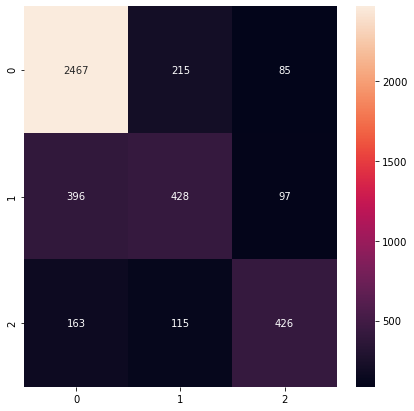

In [29]:
# plot Confusion matirx for CountVectorizer model.

# Predict the result for test data using the model built above.
y_pred = rf.predict(x_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [30]:
# TfidfVectorizer model

# Split data into training and testing set.
x_train2, x_test2, y_train2, y_test2 = train_test_split(tweets_TfidfVectorizer, sentiment, test_size=0.3, random_state=50)

# Build the classifier object and then fit it to the trainning data.
rf2 = RandomForestClassifier(n_estimators=50)
rf2 = rf2.fit(x_train2, y_train2)

# print the model performance
print("TfidfVectorizer Model Train set performance = ",np.mean(cross_val_score(rf, tweets_TfidfVectorizer, sentiment, cv=50))*100)

#Test set performance
score2 = rf2.score(x_test2,y_test2)
print('TfidfVectorizer Moel Test set performance = ',score2*100)

TfidfVectorizer Model Train set performance =  75.23182476974145
TfidfVectorizer Moel Test set performance =  76.16120218579235


[[2573  138   56]
 [ 478  365   78]
 [ 208   89  407]]


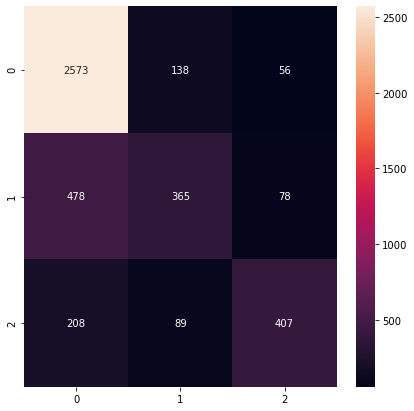

In [31]:
# plot Confusion matirx for TfidfVectorizer model.

# Predict the result for test data using the model built above.
y_pred2 = rf2.predict(x_test2)

from sklearn.metrics import confusion_matrix

conf_mat2 = confusion_matrix(y_test2, y_pred2)

print(conf_mat2)

df_cm2 = pd.DataFrame(conf_mat2, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm2, annot=True, fmt='g')

# 6. Summary


The target is to create a model for sentinemt classification between negative-neutral-positive or 0-1-2.

To remove unwanted texts and expressions which add no extra information to the calssification, I used methods and functions as 
BeautifulSoup to remove html tags, 're' to remove numbers, special characters and punctuations, 'unicodedata' to remove accented characters, WordNetLemmatizer() to lemmatize the words and enhance the process. 

The preprecessed data is converted to vectors of numbers to represent the frequency of the words and to estimate the importance and weight of each word via CountVectorizer() & TfidfVectorizer() methods, and to prepare it to be fed to the classification model.

I built Random forest classification model with 50 estimators/trees then fitted it to the train dataset, it achieves around 75% with CountVectorizer() model ,and almost the same performance with testset, while achives 76% with TfidfVectorizer() model on the test dataset which is slightly higher.


One more way to increase accuracy is to use different variations of Pre-processing techniques.